# Uporaba vektorskih predstavitev besedil

V tem zvezku predstavimo, kako lahko uporabimo vektorske predstavitve (vložitve) besed in dokumentov za analizo besedil.

## Pridobitev vektorskih vložitev

Za začetek si preko API-ja pridobimo besedila vseh predlogov vladi, ki vsebujejo vsaj 50 znakov (s tem pogojem poskrbimo, da po predprocesiranju ne dobimo praznega seznama tokenov).

In [1]:
from textsemantics.server_api import ServerAPI

api = ServerAPI()
datasets = api.list_datasets()
metadata = api.get_metadata(datasets[2][0])

In [2]:
texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]
len(texts)

9851

Dobili smo 9851 dokumentov. Zdaj lahko dokumente predprocesiramo tako, da iz njih odstranimo končnice, jih pretvorimo v seznam tokenov, odstranimo prazne besede in lematiziramo preostale tokene.

In [3]:
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = TweetTokenizer()
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

tokens_list = preprocess(texts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sedaj lahko vsak dokument predstavimo kot vektor. Vektorje bomo dobili z uporabo vreče besed, kjer vsak atribut predstavlja eno besedo v slovarju, vsaka vrstica pa en dokument. Element v i-ti vrstici in j-tem stolpcu lahko predstavlja število pojavitev j-te besede v i-tem dokumentu ali pa isto vrednost uteženo z mero tf-idf. Poleg tega bomo dokumente predstavili z uporabo modela fastText, ki temelji na nevronskih mrežah in je prednaučen na velikem korpusu dokumentov. V osnovi je fastText učen, da besede predstavi z nizkodimenzionalnimi vektorji, vendar lahko vektorje dokumentov dobimo s povprečenjem vektorjev besed, ki se v dokumentu nahajajo.

In [4]:
from flair.data import Sentence
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def vectorize(tokens_list, emb_type='fasttext'):
    joined_texts = [' '.join(tokens) for tokens in tokens_list]

    if emb_type=='fasttext':
        embedder = DocumentPoolEmbeddings([WordEmbeddings('sl')],
                                          pooling='mean')
        X = list()
        for i, doc in enumerate(joined_texts):
            sent = Sentence(doc)
            embedder.embed(sent)
            X.append(sent.embedding.cpu().detach().numpy())
        return np.array(X)
    elif emb_type == 'tfidf':
        return TfidfVectorizer().fit_transform(joined_texts)   
    return None

ft = vectorize(tokens_list, emb_type='fasttext')
tfidf = vectorize(tokens_list, emb_type='tfidf').toarray()
ft.shape, tfidf.shape

((9851, 300), (9851, 45830))

Za vložitve tf-idf smo dobili 9851 x 45830 matriko, za vložitve fastText pa 9851 x 300 matriko. 

## Računanje razdalj med dokumenti

Razdaljo med dvema dokumentoma izračunamo kot razdaljo med njihovima vektorskima predstavitvama. Ker imamo mehanizem za računanje razdalj, lahko za želeni dokument poiščemo k dokumentov, ki so mu najbližji v vektorskem prostoru. Poiščimo 3 najbližje sosede prvega dokumenta v našem seznamu.

In [5]:
def cos_sim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def knn(embs, ind=0, k=3):
    dists = [1 - cos_sim(embs[i], embs[ind]) if i != ind else 1
             for i in range(embs.shape[0])]
    inds = np.argsort(dists)
    return inds[:min(k, embs.shape[0])]

In [6]:
ft_nn = knn(ft, ind=0, k=3)
tfidf_nn = knn(tfidf, ind=0, k=3)
print(ft_nn, tfidf_nn)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


[2466 7003 8150] [2466 8150 7003]


Izkaže se, da z uporabo obeh vložitev odkrijemo iste 3 najbližje sosede. Poglejmo besedila prvega dokumenta in njegovih najbližjih sosedov.

In [7]:
print(f"Originalni dokument:\n{texts[0]}\n\n1. dokument:\n{texts[ft_nn[0]]}\n\n" +
      f"2. dokument:\n{texts[ft_nn[1]]}\n\n3. dokument:\n{texts[ft_nn[2]]}\n\n")

Originalni dokument:
 

Predlagam, da se na slovenskih semaforjih znova uvede utripajoča zelena luč, kot smo jo že imeli pred leti.  Prednost utripajoče zelene luči je v tem, da voznike predhodno opozori, da se bo prižgala rumena in se morajo na semaforju ustaviti. Mislim, da bodo s tem slovenske ceste varnejše ter promet bolj tekoč.
 
Add1.
Predlagam tudi, da se sprejme načrt uvedbe odštevalnikov na semaforjih, po katerem bi do konca leta 2012 20% vseh semaforjev v državi imelo odštevalnike (tako za zeleno kot za rdečo luč).

1. dokument:
Predlagam, da se odštevanje časa prižgane zelene luči na semaforju ukine.
 
Da so odštevalniki zelene luči  namreč podobno nevarni kot utripajoča zelena luč so ugotovili v Tajvanu (že leta 2008), kjer so na podlagi raziskave tudi uvedli spremembo zakona, ki ureja prometno signalizacijo.
http://freakonomics.blogs.nytimes.com/2008/03/14/taiwans-solution-to-t...
http://www.taipeitimes.com/News/taiwan/archives/2008/03/11/2003405001
http://www.traffictech

Vsi štirje predlogi se nanašajo na odštevalnike in utripajoče luči pri semaforjih. Na takšen enostaven način lahko za poljuben predlog vladi poiščemo obstoječe predloge, ki so mu podobni.

## Podobnost med dokumentom in besedo

Predpostavimo, da imamo seznam besed, za katere želimo vedeti, ali dobro opisujejo določeni dokument. To lahko izvemo na način podoben zgoraj opisanemu. Ker smo z modelom fastText dobili vložitve besed, nato pa le te združili v vložitve dokumentov, so tako besede kot dokumenti vektorji v istem vektorskem prostoru. Zato lahko računamo razdalje (podobnosti) med besedami in dokumenti. Vemo, da se prvi predlog vladi na seznamu nanaša na semaforje. Izračunajmo kosinusno podobnost (definirana je kot 1 - razdalja) med tem predlogom in besedami semafor, luč, zdravje in tehnologija.

In [8]:
embedder = WordEmbeddings('sl')
for word in ['semafor', 'luč', 'zdravje', 'tehnologija']:
    sent = Sentence(word)
    embedder.embed(sent)
    vec = sent.tokens[0].embedding.cpu().detach().numpy()
    print(f"Podobnost med dokumentom in besedo {word}: " + 
          f"{round(cos_sim(ft[0], vec), 4)}")

Podobnost med dokumentom in besedo semafor: 0.6075999736785889
Podobnost med dokumentom in besedo luč: 0.5390999913215637
Podobnost med dokumentom in besedo zdravje: 0.3431999981403351
Podobnost med dokumentom in besedo tehnologija: 0.397599995136261


Kot vidimo, sta besedi semafor in luč bolj podobni dokumentu kot besedi zdravje in tehnologija.

## Odkrivanje skupin in izris kart dokumentov

Dimenzionalnost vektorskih predstavitev dokumentov lahko zmanjšamo na 2, kar nam omogoča prikaz dvodimenzionalne karte dokumentov, na kateri vsaka točka predstavlja dokument. Poleg tega lahko v dvodimenzionalnem prostoru odkrijemo skupine podobnih dokumentov in vsako skupino na karti obarvamo z različno barvo. To nam omogoča dober vpogled v celotno množico dokumentov.

In [9]:
%%time
from openTSNE.sklearn import TSNE
tsne = TSNE().fit(ft)

CPU times: user 1min 4s, sys: 600 ms, total: 1min 4s
Wall time: 1min 4s


In [10]:
%%time
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=10).fit(tsne.embedding_)
labels = hdbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Število skupin: {n_clusters}, Število dokumentov, ki niso v skupinah: {n_noise}")

Število skupin: 110, Število dokumentov, ki niso v skupinah: 4374
CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 271 ms


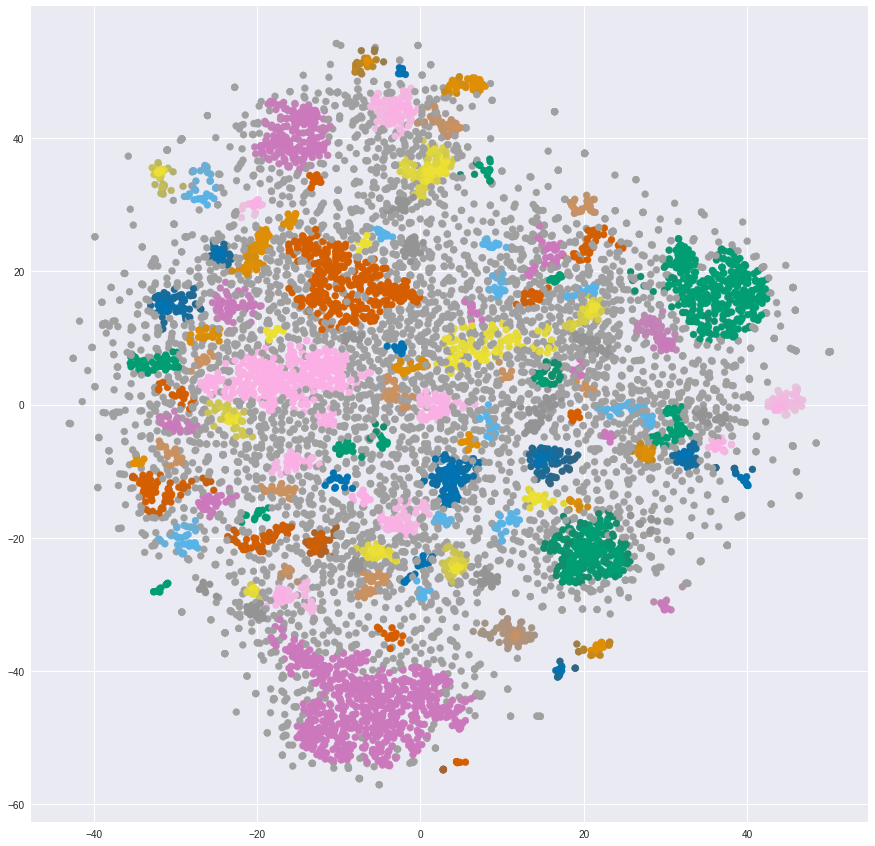

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 15))
plt.style.use('seaborn')
idx = np.where(labels > -1)[0]
palette = sns.color_palette('colorblind', n_clusters)
colors = [sns.desaturate(palette[l] if l >= -1 else (0.5, 0.5, 0.5), p) for 
          l, p in zip(hdbscan.labels_, hdbscan.probabilities_)]
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=colors, cmap=plt.get_cmap('Spectral'))

Če bi pogledali dokumente, ki se nahajajo v eni izmed skupin, bi opazili, da se nanašajo na isto ali podobno temo.